In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random
import keras_tuner as kt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from imblearn.over_sampling import SMOTE

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

## Data cleaning

In [14]:
# read csv file
insurance_df = pd.read_csv("Insurance_claims.csv")
# insurance_df.head()
insurance_df = insurance_df.drop(
    ["ReferenceId", "PolicyholderNumber", "InsurerNotes"], axis=1
)
# these are unique values which should be dropped and column about postcode and date will be dropped later
# we need to find those repeated values and set them into 1, others into 0(including the missing value)
mask = insurance_df["FirstPartyVehicleNumber"].duplicated(keep=False)
insurance_df.loc[mask, "FirstPartyVehicleNumber"] = 1
insurance_df.loc[~mask, "FirstPartyVehicleNumber"] = 0
# check if there is thirdpartyvehicle, yes -> 1, no -> 0
insurance_df["ThirdPartyVehicleNumber"].fillna(0)
insurance_df["ThirdPartyVehicleNumber"] = insurance_df["ThirdPartyVehicleNumber"].apply(
    lambda x: 1 if x > 0 else 0
)

insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(
    insurance_df["FirstPolicySubscriptionDate"]
)

# calculate the number of days between the two dates
insurance_df["days_between"] = insurance_df.apply(
    lambda row: (row["LossDate"] - row["FirstPolicySubscriptionDate"]).days, axis=1
)
insurance_df = insurance_df.drop(["LossDate", "FirstPolicySubscriptionDate"], axis=1)

# check the two postcodes
def compare_digits(x, y):
    x_len = len(str(x))
    y_len = len(str(y))
    if x_len == y_len:
        if x_len == 5:
            return str(x)[:2] == str(y)[:2]
        elif x_len == 4:
            return str(x)[0] == str(y)[0]
        else:
            return False
    else:
        return False


# check if the loss place is in the same district of the holder's place
insurance_df["IfinSameArea"] = insurance_df.apply(
    lambda row: 1
    if compare_digits(row["LossPostCode"], row["PolicyHolderPostCode"])
    else 0,
    axis=1,
)
insurance_df = insurance_df.drop(["LossPostCode", "PolicyHolderPostCode"], axis=1)

# set these columns to dummies
insurance_df = pd.get_dummies(
    insurance_df,
    columns=[
        "FirstPartyVehicleType",
        "PolicyholderOccupation",
        "ClaimCause",       
        "ConnectionBetweenParties",
        "ClaimInvolvedCovers",
    ],
)

# check the two postcodes
def jud(x):
    if x == "TotalLoss":
        return 1
    elif x == "Medium":
        return 0.5
    else:
        return 0


insurance_df["DamageImportance"] = insurance_df["DamageImportance"].fillna(0)
insurance_df["DamageImportance"] = insurance_df["DamageImportance"].apply(
    lambda row: jud(row)
)

mean_v_fp = insurance_df["FpVehicleAgeMonths"].mean()
insurance_df["FpVehicleAgeMonths"] = insurance_df["FpVehicleAgeMonths"].fillna(
    value=mean_v_fp
)

insurance_df["LossHour"] = insurance_df["LossHour"].fillna(
    insurance_df["LossHour"].mean()
)

mean_v_po = insurance_df["PolicyHolderAge"].mean()
insurance_df["PolicyHolderAge"] = insurance_df["PolicyHolderAge"].fillna(mean_v_po)

insurance_df.head()

/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_94903/1102670442.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_94903/1102670442.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(


,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,DamageImportance,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,...,ClaimInvolvedCovers_Windscreen ActLiability,ClaimInvolvedCovers_Windscreen ActLiability Burglary,ClaimInvolvedCovers_Windscreen ActLiability Burglary Theft,ClaimInvolvedCovers_Windscreen ActLiability NaturalCatastrophes,ClaimInvolvedCovers_Windscreen ActLiability Theft,ClaimInvolvedCovers_Windscreen ActLiability Theft ReplacementVehicle,ClaimInvolvedCovers_Windscreen MaterialDamages,ClaimInvolvedCovers_Windscreen MaterialDamages ActLiability,ClaimInvolvedCovers_Windscreen NaturalCatastrophes,ClaimInvolvedCovers_Windscreen Theft
0,0.0,0,0.0,1,1,104.0,0.25,1,4624.73,8.0,...,False,False,False,False,False,False,False,False,False,False
1,1.0,0,0.0,0,3,230.0,0.50,1,1606.81,11.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,0,0.0,0,9,93.0,0.25,0,998.20,18.0,...,False,False,False,False,False,False,False,False,False,False
3,0.0,0,0.0,0,2,56.0,0.25,0,2506.92,11.0,...,False,False,False,False,False,False,False,False,False,False
4,0.0,1,0.0,0,4,110.0,0.25,0,12.00,12.0,...,False,False,False,False,False,False,False,False,False,False


## Question 3

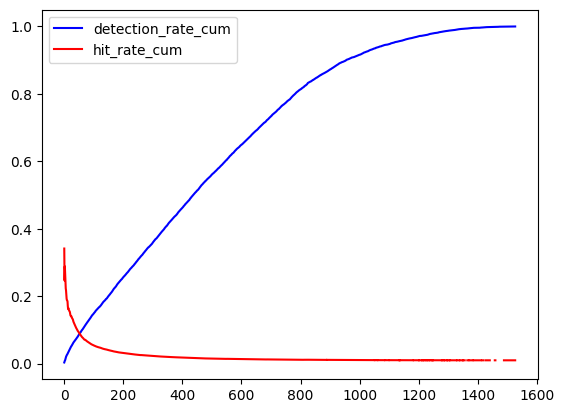

In [5]:
import numpy as np
import matplotlib.pyplot as plt

detection = insurance_df.groupby(['days_between']).size().reset_index(name='count')
detection.loc[:, "count_cum"] = detection['count'].cumsum()
detection.loc[:, "detection_rate_cum"] =  detection[['count_cum']]/len(insurance_df)
detection.loc[:, "fraud_cum"]  = insurance_df.groupby(['days_between'])[['Fraud']].sum().cumsum()
detection.loc[:, "hit_rate_cum"] = detection['fraud_cum']/detection['count_cum']


x = detection['days_between']
f = detection['detection_rate_cum']
g = detection['hit_rate_cum']

plt.plot(x, f, "-b", label="detection_rate_cum")
plt.plot(x, g, "-r", label="hit_rate_cum")
plt.legend(loc="upper left")

plt.show()

## Split and standardize data

In [48]:
y = insurance_df["Fraud"]  # creating the dependent variable
X = insurance_df.drop(columns=["Fraud"])


X_train, X_other, Y_train, Y_other = train_test_split(
    X, y, train_size=0.7, random_state=111
)


X_test, X_valid, Y_test, Y_valid = train_test_split(
    X_other, Y_other, test_size=0.5, random_state=111
)

# Apply SMOTE
smote = SMOTE(random_state=111)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


X_train_smote.shape, Y_train_smote.shape, X_test.shape

((15970, 121), (15970,), (1730, 121))

In [49]:
# Checking the shapes of the datasets
print(X_train_smote.shape, Y_train_smote.shape, X_test.shape)

(15970, 121) (15970,) (1730, 121)


In [50]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
X_vaild_scaled = scaler.transform(X_valid)
X_vaild_scaled.shape

(1730, 121)

## Boxplot analyses for potentially important feature

In [18]:
# Split the dataframe into two groups which have different results of patent application.
df_no_all = insurance_df.loc[insurance_df["Fraud"] == 0]
df_yes_all = insurance_df.loc[insurance_df["Fraud"] == 1]

# Select the parameters that assumed to be related.
list_para = ["NumberOfPoliciesOfPolicyholder","FpVehicleAgeMonths","ClaimAmount","LossHour","PolicyHolderAge","days_between"]
df_no = df_no_all[["NumberOfPoliciesOfPolicyholder","FpVehicleAgeMonths","ClaimAmount","LossHour","PolicyHolderAge","days_between"]]
df_yes = df_yes_all[["NumberOfPoliciesOfPolicyholder","FpVehicleAgeMonths","ClaimAmount","LossHour","PolicyHolderAge","days_between"]]


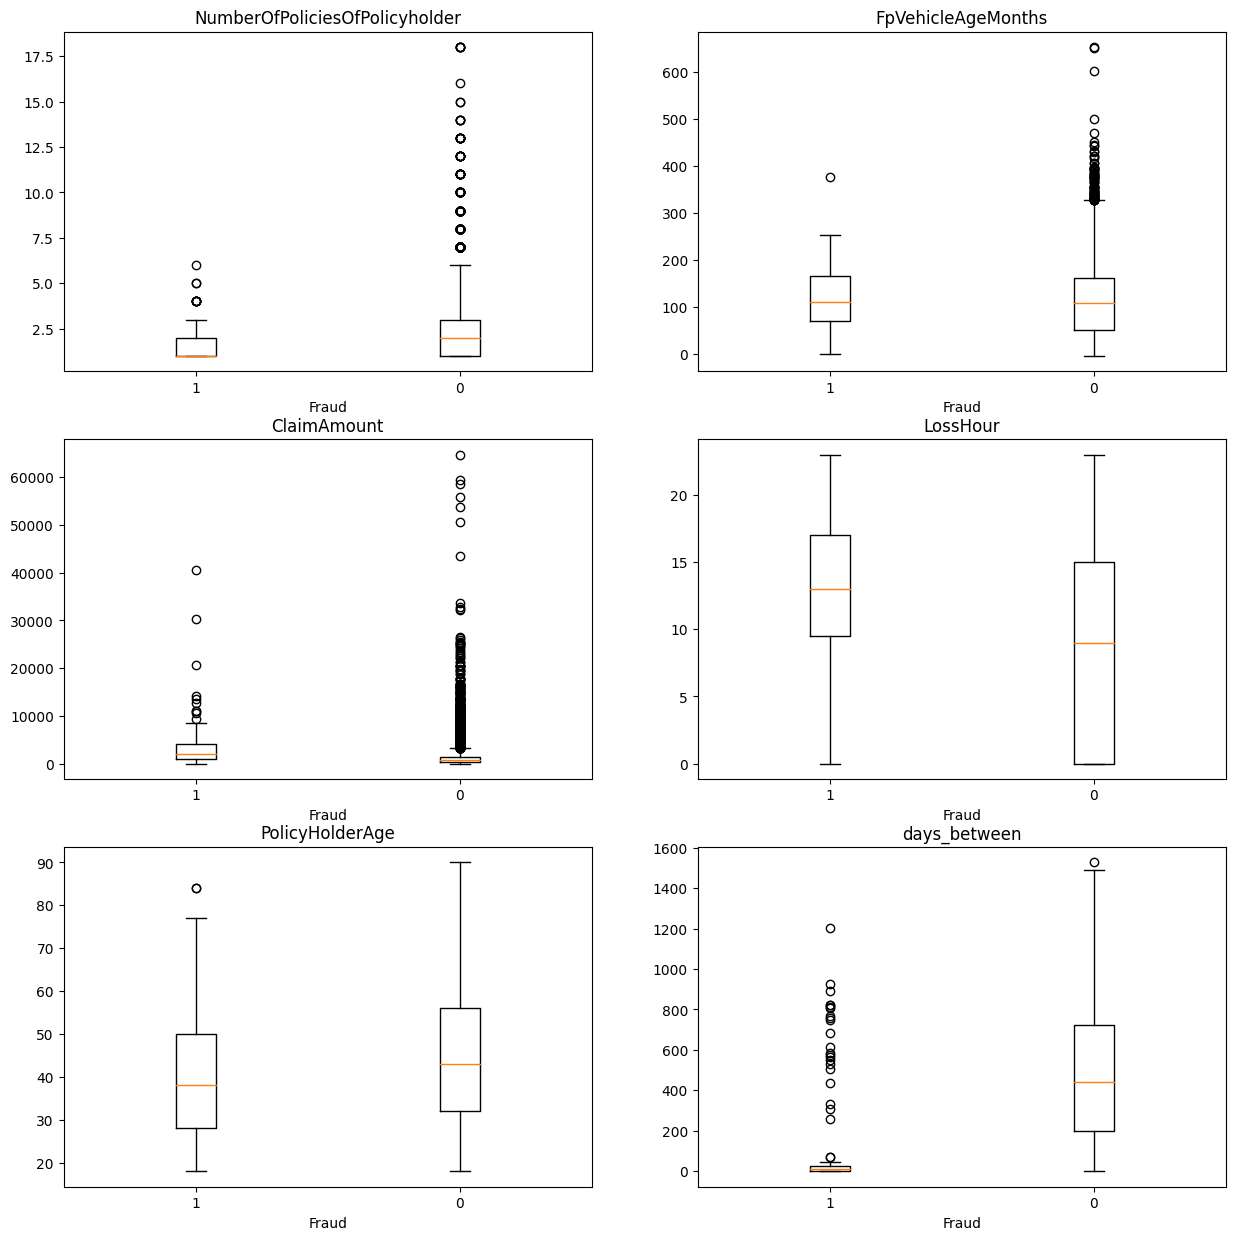

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15,15))

# Draw the box plots by iterating features
k = 0
for i in range(3):
    for j in range(2):
        if k >6:
            break
        axes[i,j].boxplot([df_yes[list_para[k]], df_no[list_para[k]]])
        axes[i,j].set_title(list_para[k])
        axes[i,j].set(xlabel = "Fraud")
        xlabels = axes[i,j].set_xticklabels(["1", "0"])
        k += 1
        

## This section includes 3 methods: 

    1. opt_threshold() calculates the optimal threshold for dealing with the network outputs based on "sigmiod" activetion function.
       The optimal threshold will be the highest f1 score of Y_vaild and y_pred_threshold.

    2. show_predicted_result() shows the hit rate, detection rate and other relevant results.

    3. create_plot() shows the model loss, accuracy, validation loss and validation accuracy.

In [63]:
def opt_threshold(model):
    # Make predictions on the test set
    y_pred = model.predict(X_vaild_scaled)

    # Calculate the F1 score for different threshold values
    f1_scores = []
    thresholds = np.arange(0.0, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_thresh = tf.keras.backend.cast(y_pred > threshold, 'float32')
        f1 = f1_score(Y_valid, y_pred_thresh)
        f1_scores.append(f1)

    # Select the threshold with the highest F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    return optimal_threshold


def show_predicted_result(model, data):
    y_pred = model.predict(data)
    y_pred = y_pred.ravel()

    mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
    print("Mean square error: ", mse)

    opt_thresh = opt_threshold(model) 

    y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

    hits = sum(Y_test & y_pred)

    hit_rate = hits / np.sum(y_pred)
    detection_rate = np.sum(y_pred) / len(y_pred)


    print("Threshold-------------------------:", opt_thresh)
    print("Number of data in testset:--------:", len(y_pred))
    print("Number of predicted frauds--------:", np.sum(y_pred))
    print("Total number of frauds in testset-:", np.sum(Y_test))
    print("Number of predicted frauds hit----:", hits)
    print("Hit rate--------------------------:", hit_rate)
    print("Detection rate--------------------:", detection_rate)
    

def create_plot(log):
    plt.plot(log.history["accuracy"], label="training accuracy", color="red")
    plt.plot(log.history["loss"], label="training loss", color="darkgreen")
    plt.plot(
        log.history["val_accuracy"],
        label="validation accuracy",
        color="grey",
    )
    plt.plot(log.history["val_loss"], label="validation loss", color="darkblue")
    plt.legend()
    plt.show()

## Question 4: Building a decision tree model

    • A default tree is given and its hit rate is lower than the neuron network's one
      when having the similar detection rates.

    1. Default decision tree
            Detection rate: 0.012, Hit rate: 0.095
  
    2. Neuron network
            Detection rate: 0.015, Hit rate: 0.154

In [67]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_smote, Y_train_smote)
Pred = dtc.predict(X_test)
hits1 = sum(Y_test & Pred)

hit_rate1 = hits1 / Pred.sum()
detection_rate1 = Pred.sum()/ len(Y_test)

print("Hit rate:", hit_rate1)
print("Detection rate:", detection_rate1)

Hit rate: 0.2571428571428571
Detection rate: 0.02023121387283237


    We also tried to see the top 27 important features and select them as the key features to see if they can help in question 6

    The features after 27th have zero importance scores, so we discarded them

In [68]:
# Create a list of tuples with feature names and their importance scores
feature_importances = [(feature, importance) for feature, importance in zip(dtc.feature_names_in_, dtc.feature_importances_)]

# Sort the list of feature importances in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the first 10 most important features
for feature, importance in feature_importances[:30]:
    print(f"{feature}: {importance:.4f}")

days_between: 0.5081
ConnectionBetweenParties_SameAddress: 0.1516
DamageImportance: 0.1203
ClaimAmount: 0.0396
ClaimCause_WindscreenDamage: 0.0275
ConnectionBetweenParties_SamePolice: 0.0204
PolicyHolderAge: 0.0202
LossHour: 0.0137
EasinessToStage: 0.0133
FirstPartyLiability: 0.0127
FirstPartyVehicleNumber: 0.0121
ClaimCause_LossOfControl: 0.0112
FpVehicleAgeMonths: 0.0064
NumberOfBodilyInjuries: 0.0054
PolicyholderOccupation_Retired: 0.0046
ClaimCause_TotalTheft: 0.0045
PolicyholderOccupation_Employee: 0.0044
NumberOfPoliciesOfPolicyholder: 0.0033
PolicyholderOccupation_Worker: 0.0027
ClaimCause_Flood: 0.0025
ClaimInvolvedCovers_ActLiability Fire: 0.0017
PolicyWasSubscribedOnInternet: 0.0015
ClaimInvolvedCovers_MaterialDamages ActLiability: 0.0013
ClaimInvolvedCovers_MaterialDamages ActLiability ReplacementVehicle: 0.0012
ClaimCause_CollisionWithAnimal: 0.0012
FirstPartyVehicleType_Car: 0.0010
ClaimCause_AccidentWithUnidentifiedThirdParty: 0.0010
PolicyholderOccupation_Unemployed: 0.0

## Question 5: Building a deep neuron network

    We first create a hyperparameter searching space for Hyperband tuner to train and search the best model

    • 5 hyperparameters are tuned and 3 optimizers as well
    • Leaky relu is used as a choice to capture more negative inputs with alpha = 0.2, improving the "dying relu" problem
    • Batch normalisation layers help the network to converge faster
    • 10 metrics will be output by the model
     

In [80]:
def train_model(hp):

    # 5 hyperparameters to tune
    n_hiddens = hp.Int("n_hiddens", min_value=2, max_value=16, step=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=64, step=8)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.9, step=0.1)
    # print("Current dropout rate:", dropout_rate)  # Debugging line
    learning_rate = hp.Float(
        "learning_rate", min_value=0.001, max_value=0.05, sampling="log"
    )
    
    model = tf.keras.Sequential(
        [tf.keras.layers.Flatten(input_shape=(121, 1))]
    )
    
    for _ in range(n_hiddens):
        
        model.add(
            tf.keras.layers.Dense(
                n_neurons,
                activation = tf.keras.layers.LeakyReLU(0.2),
                )
        )
        tf.keras.layers.BatchNormalization(),
        # model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    METRICS = [
      tf.keras.metrics.MeanSquaredError(name='mse'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(
        # optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
        optimizer=optimizer, loss='binary_crossentropy', 
                  metrics=METRICS
    )

    return model

## Calculate a weight ratio for frauds and non frauds data

    • Adding more weights on the fraud data as they are only 1% of the total dataset
    
    • The purpose of doing this is to let the neuron network pays more attention on the fraud data in the training process

In [34]:
neg, pos = np.bincount(insurance_df['Fraud'])
total = neg + pos
print('Total: {}\nFrauds: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1+10}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total: 11530
Frauds: 115 (1.00% of total)

Weight for class 0: 0.51
Weight for class 1: 50.13


## Hyperband tuner 

    • The tuner objective is to find the best "val_accuracy", despite it is not the task goal
    • A better model "best_hb_model" was saved after several model fittings for comparing with result from decision tree

In [76]:
hyperband_tuner = kt.Hyperband(
    train_model,
    # objective=kt.Objective("rmse", direction="min"),
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory="logs",
    project_name="hb_tuner1",
    
)

hyperband_tuner.search(X_train_scaled, Y_train_smote, validation_data=(X_vaild_scaled, Y_valid))


Trial 10 Complete [00h 01m 19s]
val_accuracy: 0.9930635690689087

Best val_accuracy So Far: 0.9930635690689087
Total elapsed time: 00h 06m 08s
INFO:tensorflow:Oracle triggered exit


In [77]:
best_hps = hyperband_tuner.get_best_hyperparameters()[0]
best_hb_model = hyperband_tuner.hypermodel.build(best_hps)

In [82]:
# set a early stopping for saving time during model fitting
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
    mode='max'
)  

# fitting the model 
log = best_hb_model.fit(
    X_train_scaled,
    Y_train_smote,
    epochs=30,
    batch_size=512,
    validation_data=(X_vaild_scaled, Y_valid),
)

Epoch 1/30


2024-02-02 23:12:22.961944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x1x1xi1>'
l

30/32 [===========================>..] - ETA: 0s - loss: 0.6928 - mse: 0.2498 - tp: 7632.0000 - fp: 7019.0000 - tn: 653.0000 - fn: 56.0000 - accuracy: 0.5394 - precision: 0.5209 - recall: 0.9927 - auc: 0.4993 - prc: 0.4957

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x98x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x98x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

32/32 [==============================] - ETA: 0s - loss: 0.6928 - mse: 0.2498 - tp: 7903.0000 - fp: 7160.0000 - tn: 825.0000 - fn: 82.0000 - accuracy: 0.5465 - precision: 0.5247 - recall: 0.9897 - auc: 0.4991 - prc: 0.4949

2024-02-02 23:12:26.354560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x1x1xi1>'
l

32/32 [==============================] - 6s 112ms/step - loss: 0.6928 - mse: 0.2498 - tp: 7903.0000 - fp: 7160.0000 - tn: 825.0000 - fn: 82.0000 - accuracy: 0.5465 - precision: 0.5247 - recall: 0.9897 - auc: 0.4991 - prc: 0.4949 - val_loss: 0.6933 - val_mse: 0.2501 - val_tp: 4.0000 - val_fp: 608.0000 - val_tn: 1109.0000 - val_fn: 9.0000 - val_accuracy: 0.6434 - val_precision: 0.0065 - val_recall: 0.3077 - val_auc: 0.4817 - val_prc: 0.0068
Epoch 2/30
 1/32 [..............................] - ETA: 1s - loss: 0.6926 - mse: 0.2497 - tp: 208.0000 - fp: 77.0000 - tn: 163.0000 - fn: 64.0000 - accuracy: 0.7246 - precision: 0.7298 - recall: 0.7647 - auc: 0.4913 - prc: 0.5145

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x194x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x194x1x1xi1>'


32/32 [==============================] - 1s 35ms/step - loss: 0.6924 - mse: 0.2496 - tp: 6856.0000 - fp: 3712.0000 - tn: 4273.0000 - fn: 1129.0000 - accuracy: 0.6969 - precision: 0.6488 - recall: 0.8586 - auc: 0.5139 - prc: 0.5111 - val_loss: 0.6962 - val_mse: 0.2515 - val_tp: 13.0000 - val_fp: 1441.0000 - val_tn: 276.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.1671 - val_precision: 0.0089 - val_recall: 1.0000 - val_auc: 0.4663 - val_prc: 0.0066
Epoch 3/30
32/32 [==============================] - 1s 34ms/step - loss: 0.6919 - mse: 0.2494 - tp: 7437.0000 - fp: 4319.0000 - tn: 3666.0000 - fn: 548.0000 - accuracy: 0.6952 - precision: 0.6326 - recall: 0.9314 - auc: 0.5861 - prc: 0.5714 - val_loss: 0.6942 - val_mse: 0.2505 - val_tp: 7.0000 - val_fp: 809.0000 - val_tn: 908.0000 - val_fn: 6.0000 - val_accuracy: 0.5289 - val_precision: 0.0086 - val_recall: 0.5385 - val_auc: 0.4523 - val_prc: 0.0063
Epoch 4/30
32/32 [==============================] - 1s 33ms/step - loss: 0.6915 - mse: 0.2492 - 

In [83]:
show_predicted_result(best_hb_model, X_test_scaled)

55/55 [==============================] - 0s 6ms/step
Mean square error:  0.024751556454198794
55/55 [==============================] - 0s 5ms/step
Threshold-------------------------: 0.34
Number of data in testset:--------: 1730
Number of predicted frauds--------: 44
Total number of frauds in testset-: 17
Number of predicted frauds hit----: 0
Hit rate--------------------------: 0.0
Detection rate--------------------: 0.025433526011560695


## Above code is for we to try out to find a good model that can beat the decision tree. So the output above is different, but we saved the best model as below

## Saving the best model above for model comparison of decison tree and future uses

    • Only need to run once

## Loading the saved model to predict new data


In [105]:
# tf.keras.models.save_model(best_hb_model, "final_model_better_then_dt")

final_model = tf.keras.models.load_model("final_model_better_then_dt")
final_model.load_weights("final_model_better_then_dt")

show_predicted_result(final_model, X_test_scaled)

15/55 [=======>......................] - ETA: 0s

2023-03-08 14:23:12.963775: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open final_model_better_then_dt: FAILED_PRECONDITION: final_model_better_then_dt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-03-08 14:23:13.034159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 0s 4ms/step
Mean square error:  0.03130440940386984
55/55 [==============================] - 0s 3ms/step
Threshold-------------------------: 0.97
Number of data in testset:--------: 1730
Number of predicted frauds--------: 26
Total number of frauds in testset-: 17
Number of predicted frauds hit----: 4
Hit rate--------------------------: 0.15384615384615385
Detection rate--------------------: 0.015028901734104046


## Result of the network:
     The hit rate and detection rate of the network are all higher than the decision 

        1. Default decision tree
                Detection rate: 0.012, Hit rate: 0.095
        
        2. Neuron network
                Detection rate: 0.015, Hit rate: 0.154

## Question 6

## 2D convolution network try out, but not good for the final result

In [ ]:
# Normalisation, turn the dataframe into arrays
scaler = StandardScaler()
X_strain = scaler.fit_transform(X_train)
X_stest = scaler.transform(X_test)
X_svali = scaler.transform(X_vali)

# Save the value of the largest absolute value in all dataset as the scaler
scaler_to1 = X_strain.max()

# Scale datasets with the same standard: scaler_to1
X_atrain = X_strain/scaler_to1
X_avali = X_svali/scaler_to1
X_atest = X_stest/scaler_to1
X_atrain

X_atrain = X_atrain.reshape(6849, 11, 11)
X_avali = X_avali.reshape(1405, 11, 11)
X_atest = X_atest.reshape(3276, 11, 11)

noise = 0.2

X_train_noisy = X_atrain + noise * tf.random.normal(shape=X_atrain.shape) 
X_vali_noisy = X_avali + noise * tf.random.normal(shape=X_avali.shape)
X_test_noisy = X_atest + noise * tf.random.normal(shape=X_atest.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_vali_noisy = tf.clip_by_value(X_vali_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)


encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((11,11,1), input_shape=(11,11)),
    tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='valid', strides=2),
    tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='valid', strides=2)], name='encoder')


decoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='relu', padding='valid'),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, activation='relu', padding='valid'),
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')], name='decoder')


autoencoder = tf.keras.Sequential([encoder,decoder])

autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

autoencoder.fit(x=X_train_noisy, y=X_atrain, epochs=10,
                batch_size=32, validation_data=(X_vali_noisy, X_avali))

test_encoded = encoder(X_test_noisy)
test_output = decoder(test_encoded)

# Predict the labels for the validation set
#val_pred = autoencoder.predict(df_val)
val_mse = np.mean(np.power(output - X_stest, 2), axis=1)

# Separate the fraudulent and non-fraudulent claims in the validation set
fraud_mask = np.array(Y_test) == 1

# Plot the histogram of errors for the validation set
plt.hist(val_mse[~fraud_mask], bins=50, log = True, label='non-fraudulent')
plt.hist(val_mse[fraud_mask], bins=50, log = True, label='fraudulent')
plt.xlabel('Mean Squared Error')
plt.ylabel('Number of Claims')
plt.legend()

#val_mse = val_mse.reset_index(drop=True)

# Mark the mean error for fraudulent and non-fraudulent claims
val_indices = np.arange(len(val_mse))

## Split the data as required

In [40]:
insurance_df = pd.read_csv("insurance_50cols.csv")# Divide fraudulent and non-fraudulent observations
df_frau = insurance_df.loc[insurance_df["Fraud"] == 1]
df_nofr = insurance_df.loc[insurance_df["Fraud"] == 0]
# Build X set and y set
X_frau = df_frau.drop(columns=["Fraud"])
Y_frau = df_frau["Fraud"]
X_nofr = df_nofr.drop(columns=["Fraud"])
Y_nofr = df_nofr["Fraud"]
print("X with fraud:", X_frau.shape)
print("X without fraud:", X_nofr.shape)
print("proportion:", X_frau.shape[0] / X_nofr.shape[0])

# Split Train & Other dataset without fraudulent observations
X_train_1, X_other_1, Y_train_1, Y_other_1 = train_test_split(
    X_nofr, Y_nofr, test_size=0.3, shuffle=False
)
print("X_train_1:", X_train_1.shape)
print("X_other_1:", X_other_1.shape)
# Split Vali & Test dataset without fraudulent observations
X_test_n, X_vali_n, Y_test_n, Y_vali_n = train_test_split(
    X_other_1, Y_other_1, test_size=0.5, shuffle=False
)
print("X_test_n:", X_test_n.shape)
print("X_vali_n:", X_vali_n.shape)

# Split fraudulent observations equally
X_test_y, X_vali_y, Y_test_y, Y_vali_y = train_test_split(
    X_frau, Y_frau, test_size=0.5, shuffle=False
)
print("X_test_y:", X_test_y.shape)
print("X_vali_y:", X_vali_y.shape)

# Concate observations with / without fraudulent observations in test & vali dataset
X_test_1 = pd.concat([X_test_n, X_test_y], axis=0, ignore_index=True)
Y_test_1= pd.concat([Y_test_n, Y_test_y], axis=0, ignore_index=True)
X_vali_1 = pd.concat([X_vali_n, X_vali_y], axis=0, ignore_index=True)
Y_vali_1 = pd.concat([Y_vali_n, Y_vali_y], axis=0, ignore_index=True)

print("X_train_1:", X_train_1.shape)
print("X_test_1:", X_test_1.shape)
print("Y_test_1:", Y_test_1.shape)
print("X_vali_1:", X_vali_1.shape)

X with fraud: (115, 52)
X without fraud: (11415, 52)
proportion: 0.010074463425317565
X_train_1: (7990, 52)
X_other_1: (3425, 52)
X_test_n: (1712, 52)
X_vali_n: (1713, 52)
X_test_y: (57, 52)
X_vali_y: (58, 52)
X_train_1: (7990, 52)
X_test_1: (1769, 52)
Y_test_1: (1769,)
X_vali_1: (1771, 52)


In [2]:
insurance_df = pd.read_csv("insurance_50cols.csv")
df_frau = insurance_df.loc[insurance_df["Fraud"] == 1]
df_nofr = insurance_df.loc[insurance_df["Fraud"] == 0]

nofraud_train_df, nofraud_test_df = train_test_split(df_nofr, test_size=0.3, shuffle=False)
fraud_test_df, fraud_valid_df = train_test_split(df_frau, test_size=0.5, shuffle=False)

nofraud_test_df, nofraud_valid_df = train_test_split(nofraud_test_df, test_size=0.5, shuffle=False)
nofraud_test_df.shape, nofraud_valid_df.shape

((1712, 53), (1713, 53))

In [8]:
test_df.shape, valid_df.shape

((1769, 53), (1771, 53))

((7990, 52), (1769, 52), (1771, 52))

In [10]:
test_y = test_df["Fraud"]
nofraud_train_y = nofraud_train_df["Fraud"]
valid_y = valid_df["Fraud"]
nofraud_train_y.shape, valid_y.shape, test_y.shape

((7990,), (1771,), (1769,))

In [4]:
insurance_df = pd.read_csv("insurance_50cols.csv")
# Create a training set with only non-fraudulent claims
train_data = insurance_df[insurance_df['Fraud'] == 0]

# Split the remaining data into validation and test sets
val_data, test_data = train_test_split(insurance_df[insurance_df['Fraud'] == 1], test_size=0.5)

# Append the non-fraudulent claims to the validation and test sets
val_data = pd.concat([val_data, train_data.sample(n=len(val_data), random_state=42)])
test_data = pd.concat([test_data, train_data.sample(n=len(test_data), random_state=42)])

# Shuffle the validation and test sets
val_data = val_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)


In [8]:

train_data

,ThirdPartyVehicleNumber,DamageImportance,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,...,FirstPartyVehicleType_Car,FirstPartyVehicleType_Caravan,FirstPartyVehicleType_Motorcycle,FirstPartyVehicleType_PrivateCar,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,IfinSameArea
0,0,0.0,1,1,104.0,0.25,1,4624.73,8.0,45.0,...,1,0,0,0,0,0,0,0,0,1
1,0,0.0,0,3,230.0,0.50,1,1606.81,11.0,20.0,...,1,0,0,0,0,0,0,0,0,1
2,0,0.0,0,9,93.0,0.25,0,998.20,18.0,32.0,...,1,0,0,0,0,0,0,0,0,1
3,0,0.0,0,2,56.0,0.25,0,2506.92,11.0,46.0,...,1,0,0,0,0,0,0,0,0,1
4,1,0.0,0,4,110.0,0.25,0,12.00,12.0,28.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,0,0.0,0,1,85.0,0.50,1,1010.23,0.0,56.0,...,1,0,0,0,0,0,0,0,0,0
11526,0,0.0,0,3,119.0,0.50,1,154.35,0.0,54.0,...,1,0,0,0,0,0,0,0,0,0
11527,0,0.0,0,4,139.0,0.50,1,420.25,0.0,34.0,...,1,0,0,0,0,0,0,0,0,0
11528,0,0.0,0,6,105.0,0.50,1,96.40,0.0,58.0,...,1,0,0,0,0,0,0,0,0,0


In [127]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(insurance_df.drop(columns=["Fraud"]))
X_vali_scaled = scaler.transform(valid_x)
X_test_scaled = scaler.transform(test_x)

In [124]:
# # Define the AnomalyDetector class
class AnomalyDetector(Model):
    def __init__(self, encoder, decoder):
        super(AnomalyDetector, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Set up a tuner for encode and decoder

    • 3 parameters were tunned

In [60]:
import keras_tuner as kt


def build_model(hp):

    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5)
    learning_rate = hp.Float(
        "learning_rate", min_value=0.001, max_value=0.01, sampling="log"
    )
    regulizer = hp.Choice("regulizer", values=["None", "l1", "l2", "l1_l2"])

    model = tf.keras.Sequential()
    model.add(
        layers.Dense(
            hp.Int("neurons1", min_value=32, max_value=50, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            hp.Int("neurons2", min_value=24, max_value=31, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            hp.Int("neurons3", min_value=16, max_value=23, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            hp.Int("neurons4", min_value=8, max_value=15, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            hp.Int("neurons5", min_value=16, max_value=24, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            hp.Int("neurons6", min_value=25, max_value=32, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            hp.Int("neurons7", min_value=33, max_value=48, step=2),
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
            kernel_initializer="he_normal"
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.Dense(units=52, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse"
    )
    return model


def get_regularizer(regulizer):
    if regulizer == "None":
        return None
    elif regulizer == "l1":
        return tf.keras.regularizers.l1(0.01)
    elif regulizer == "l2":
        return tf.keras.regularizers.l2(0.01)
    elif regulizer == "l1_l2":
        return tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)
    else:
        raise ValueError(f"Unknown regulizer type {regulizer}")


tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=1,
    factor=2,
    directory="logs",
    project_name="anomaly_detector5",
)

In [61]:
import keras_tuner as kt


def build_model(hp):

    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.8)
    learning_rate = hp.Float(
        "learning_rate", min_value=0.001, max_value=0.01, sampling="log"
    )
    regulizer = hp.Choice("regulizer", values=["None", "l1", "l2", "l1_l2"])

    model = tf.keras.Sequential()
    model.add(
        layers.Dense(
            32,
            activation="tanh",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            24,
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            16,
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            8,
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )



    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            16,
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )
 
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            24,
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(
        layers.Dense(
            32,
            activation="relu",
            kernel_regularizer=get_regularizer(regulizer),
        )
    )

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.Dense(units=52, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse"
    )
    return model


def get_regularizer(regulizer):
    if regulizer == "None":
        return None
    elif regulizer == "l1":
        return tf.keras.regularizers.l1(0.01)
    elif regulizer == "l2":
        return tf.keras.regularizers.l2(0.01)
    elif regulizer == "l1_l2":
        return tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)
    else:
        raise ValueError(f"Unknown regulizer type {regulizer}")


tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=2,
    factor=3,
    directory="logs",
    project_name="anomaly_detector",
)

INFO:tensorflow:Reloading Oracle from existing project logs/anomaly_detector/oracle.json
INFO:tensorflow:Reloading Tuner from logs/anomaly_detector/tuner0.json


In [62]:
tuner.search(X_train_scaled, X_train_scaled, epochs=5, validation_data=(X_vali_scaled, X_vali_scaled))
best_model = tuner.get_best_models()[0]

NameError: name 'X_vali_scaled' is not defined

In [130]:
autoencoder = AnomalyDetector(best_model, best_model)

autoencoder.compile(optimizer="nadam", loss="mse")

history = autoencoder.fit(
    X_train_scaled, X_train_scaled, epochs=30, batch_size=1024, validation_data=(X_vali_scaled, X_vali_scaled)
)

Epoch 1/30


2023-03-09 02:04:15.275309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.0546

2023-03-09 02:04:44.455375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 34s 2s/step - loss: 0.0546 - val_loss: 0.0491
Epoch 2/30
12/12 [==============================] - 4s 391ms/step - loss: 0.0528 - val_loss: 0.0492
Epoch 3/30
12/12 [==============================] - 3s 294ms/step - loss: 0.0522 - val_loss: 0.0493
Epoch 4/30
12/12 [==============================] - 2s 175ms/step - loss: 0.0520 - val_loss: 0.0493
Epoch 5/30
12/12 [==============================] - 1s 95ms/step - loss: 0.0517 - val_loss: 0.0493
Epoch 6/30
12/12 [==============================] - 1s 106ms/step - loss: 0.0516 - val_loss: 0.0493
Epoch 7/30
12/12 [==============================] - 2s 161ms/step - loss: 0.0515 - val_loss: 0.0493
Epoch 8/30
12/12 [==============================] - 1s 83ms/step - loss: 0.0515 - val_loss: 0.0494
Epoch 9/30
12/12 [==============================] - 1s 117ms/step - loss: 0.0513 - val_loss: 0.0494
Epoch 10/30
12/12 [==============================] - 3s 226ms/step - loss: 0.0513 - val_loss: 0.0493
Epoch 11/30
12

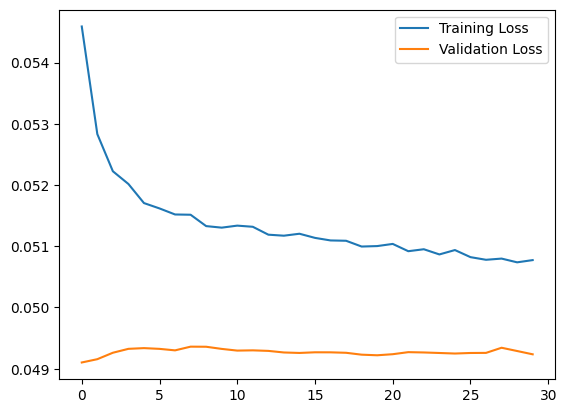

In [131]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

361/361 [==============================] - 3s 9ms/step


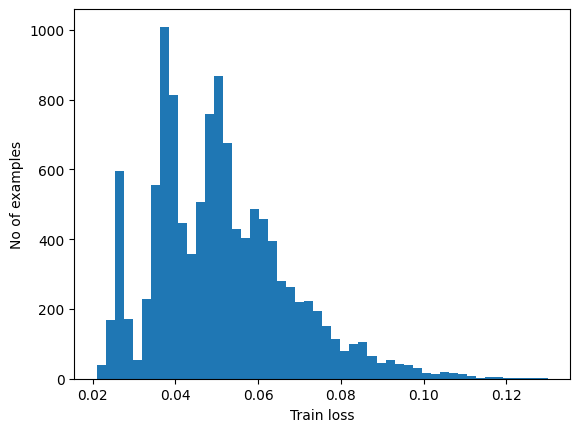

In [137]:
reconstructions = autoencoder.predict(X_train_scaled)
train_loss = tf.keras.losses.mse(reconstructions, X_train_scaled)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## Set up threshold

In [138]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.06745344060160016


56/56 [==============================] - 1s 11ms/step


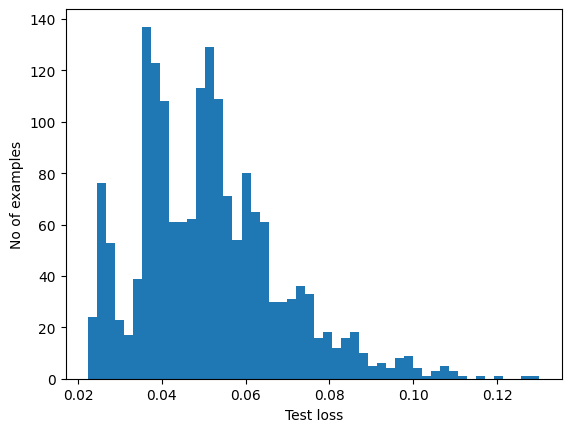

In [139]:
reconstructions = autoencoder.predict(X_test_scaled)
test_loss = tf.keras.losses.mse(reconstructions, X_test_scaled)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [140]:
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Hit rate = {}".format(precision_score(labels, predictions)))

    print("Detection rate = {}".format(np.sum(predictions)/ len(labels)))
    

## Output results for hit and detection rates

In [141]:
preds = predict(autoencoder, X_vali_scaled, threshold)
print_stats(preds, valid_y)

56/56 [==============================] - 1s 11ms/step
Accuracy = 0.13099943534726144
Hit rate = 0.0231809401159047
Detection rate = 0.8769057029926595


56/56 [==============================] - 1s 12ms/step


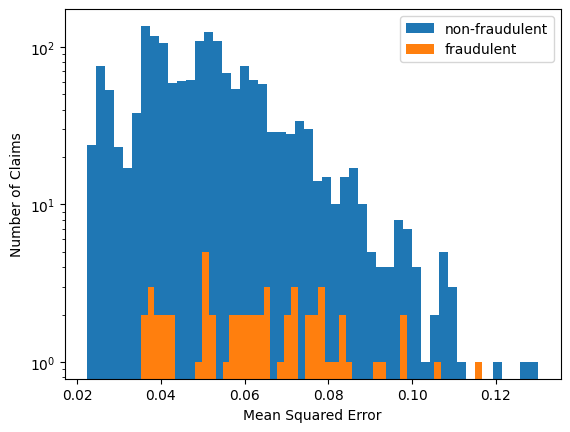

In [142]:
df_val = autoencoder.predict(X_test_scaled)

val_mse = np.mean(np.power(df_val - X_test_scaled, 2), axis=1)

# Separate the fraudulent and non-fraudulent claims in the validation set
fraud_mask = np.array(test_y) == 1

# Plot the histogram of errors for the validation set
plt.hist(val_mse[~fraud_mask], bins=50, log=True, label="non-fraudulent")
plt.hist(val_mse[fraud_mask], bins=50, log=True, label="fraudulent")
plt.xlabel("Mean Squared Error")
plt.ylabel("Number of Claims")
plt.legend()

# val_mse = val_mse.reset_index(drop=True)

# Mark the mean error for fraudulent and non-fraudulent claims
val_indices = np.arange(len(val_mse))

In [115]:
tf.keras.backend.clear_session()

## result summary for autoencoder
    
    The results of hit and detection rates are worse than the neuron network's one. It detects a large number of false positive.
    